In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3" # choose which GPU you want to use

from tempfile import gettempdir
import urllib
import zipfile
import numpy as np
import random
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

1.11.0


In [2]:
def fully_connected_layer(x_inputs, out_dim, name='fc'):
    in_dim = x_inputs.shape[-1] # feature_dims
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        weights = tf.get_variable("weights", shape=[in_dim, out_dim])
        bias = tf.get_variable("bias", shape=[out_dim])
        out = tf.matmul(x_inputs, weights) + bias
        tf.summary.histogram(name + '_Weights', weights)
        tf.summary.histogram(name + '_bias', bias)
        return out

# 1. XOR

In [3]:
# xor task
xor_data = np.array([[1, 0],
                    [0, 1],
                    [1, 1],
                    [0, 0]])
xor_label = np.array([[1], [1], [0], [0]])

In [4]:
graph_dir = "tensorboard/"
os.makedirs(graph_dir)
learning_rates=0.1
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Graph().as_default() as g:
    x_input = tf.placeholder(tf.float32, [None, 2])
    y_label = tf.placeholder(tf.float32, [None, 1])
    """ Build the model """
    with tf.name_scope("model"):
        fc = fully_connected_layer(x_input, 5, "fc")
        fc_act = tf.nn.sigmoid(fc)
        logits = fully_connected_layer(fc_act, 1, "logits")
        out = tf.nn.sigmoid(logits)
    """ Define the loss """
    with tf.name_scope("loss"):
        cross_entropy = - tf.reduce_mean((y_label * tf.log(out)) + (1 - y_label) * tf.log(1.0 - out))
        tf.summary.scalar('loss', cross_entropy)
    """ Define the optimizer """
    with tf.name_scope("optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rates).minimize(cross_entropy)
    """ Other tensors or operations you need """
    with tf.name_scope("accuracy"):
        predict = tf.to_int32(out > 0.5)
        label = tf.to_int32(y_label)
        acc = tf.contrib.metrics.accuracy(predict, label)
        tf.summary.scalar('acc', acc)
    merged = tf.summary.merge_all()
    
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(graph_dir, sess.graph)
    for epoch in range(6000):
        sess.run([cross_entropy, optimizer], feed_dict={x_input:xor_data, y_label:xor_label})
        result,_,_= sess.run([merged, acc, cross_entropy], feed_dict={x_input:xor_data, y_label:xor_label})
        writer.add_summary(result, epoch)
    output, accuracy = sess.run([predict, acc], feed_dict={x_input:xor_data, y_label:xor_label})
    print('Output:',output)
    print('Accuracy', accuracy)
    layer1 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='fc')
    layer2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='logits')
    weight1, bias1 = sess.run(layer1, feed_dict={x_input:xor_data, y_label:xor_label})
    weight2, bias2 = sess.run(layer2, feed_dict={x_input:xor_data, y_label:xor_label})
    print('Weight1:', weight1)
    print('Weight2:', weight2)
    print('bias1:', bias1)
    print('bias2:', bias2)
   
    

Output: [[1]
 [1]
 [0]
 [0]]
Accuracy 1.0
Weight1: [[-5.611801    4.257259   -0.6087842  -0.5332202   2.6356094 ]
 [-5.6286707   4.235334   -0.70896834 -0.5122275   2.61812   ]]
Weight2: [[-8.275614 ]
 [-8.775517 ]
 [ 1.5338864]
 [ 0.7964897]
 [ 2.9827402]]
bias1: [ 2.1054301  -6.468249    0.67644256 -0.24008727 -0.04303245]
bias2: [0.78266037]


# 2. MNIST

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
# load mnist data
mnist = input_data.read_data_sets("data/mnist", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/mnist\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/mnist\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/mnist\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/mnist\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [6]:
print("training data size: {}".format(mnist.train.num_examples))
print("validation data size: {}".format(mnist.validation.num_examples))
print("testing data size: {}".format(mnist.test.num_examples))

print("Shape of image: {}".format(mnist.train.images[0].shape))
print("Shape of label: {}".format(mnist.train.labels[0].shape))

training data size: 55000
validation data size: 5000
testing data size: 10000
Shape of image: (784,)
Shape of label: (10,)


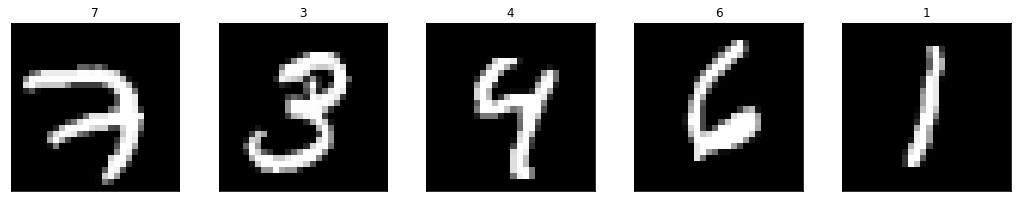

In [7]:
n = 5
plt.figure(figsize=(18,18))
for i in range(5):
    plt.subplot(n, n, i+1)
    plt.imshow(mnist.train.images[i].reshape(28,28), cmap='gray')
    plt.title(np.argmax(mnist.train.labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [8]:
graph_dir = "tensorboard_mnist/"
os.makedirs(graph_dir)
learning_rates=0.1
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Graph().as_default() as g:
    x_input = tf.placeholder(tf.float32, [None, 784])
    y_label = tf.placeholder(tf.float32, [None, 10])
    batch = tf.placeholder(tf.int64, [])
    """ Define dataset and iterator """
    with tf.name_scope("data"):
        training_dataset = tf.data.Dataset.from_tensor_slices((x_input, y_label))
        training_dataset = training_dataset.repeat()
        training_dataset = training_dataset.batch(batch)
        training_iterator = training_dataset.make_initializable_iterator()
        x_batch, y_batch = training_iterator.get_next()
    """ Build the model """
    with tf.name_scope("model"):
        fc_1 = fully_connected_layer(x_batch, 20, "fc_1")
        fc_1_act = tf.nn.relu(fc_1)
        fc_2 = fully_connected_layer(fc_1_act, 30, "fc_2")
        fc_2_act = tf.nn.relu(fc_2)
        fc_3 = fully_connected_layer(fc_2_act, 10, "fc_3")
        out = tf.nn.softmax(fc_3, axis=1, name="out")
    """ Define the loss """
    with tf.name_scope("loss"):
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_batch * tf.log(out), reduction_indices=[1]))
        tf.summary.scalar('loss', cross_entropy)
    """ Define the optimizer """
    with tf.name_scope("optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rates).minimize(cross_entropy)
    """ Other tensors or operations you need """
    with tf.name_scope("accuracy"):
        predict = tf.argmax(out,axis=1)
        #predict = tf.to_int64(predict)
        label = tf.to_int64(y_batch)
        label = tf.argmax(label, axis=1)
        acc = tf.contrib.metrics.accuracy(predict, label)
        tf.summary.scalar('acc', acc)
    merged = tf.summary.merge_all()

with tf.Session(graph=g) as sess:
    batch_size=128
    sess.run(tf.global_variables_initializer())
    sess.run(training_iterator.initializer, feed_dict={x_input:mnist.train.images, y_label:np.float32(mnist.train.labels), batch:batch_size})
    writer = tf.summary.FileWriter(graph_dir, sess.graph)
    for step in range(10000):
        result, accuracy, loss, _ = sess.run([merged, acc, cross_entropy, optimizer])
        writer.add_summary(result, step)
    sess.run(training_iterator.initializer, feed_dict={x_input:mnist.train.images, y_label:np.float32(mnist.train.labels), batch:10000})    
    print('Testing Accuracy:', sess.run(acc))
    layer1 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='fc_1')
    layer2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='fc_2')
    layer3 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='fc_3')
    weight1, bias1 = sess.run(layer1)
    weight2, bias2 = sess.run(layer2)
    weight3, bias3 = sess.run(layer3)
    print('Weight1:', weight1)
    print('Weight2:', weight2)
    print('Weight3:', weight3)
    print('bias1:', bias1)
    print('bias2:', bias2)
    print('bias3:', bias3)

Testing Accuracy: 0.98
Weight1: [[ 0.05670495 -0.06506355  0.07787108 ...  0.0033108   0.04656528
  -0.03259271]
 [ 0.0823272   0.02469745 -0.04004113 ... -0.0314298   0.04161467
  -0.08434916]
 [ 0.00326069  0.02524059 -0.05287787 ... -0.02446401  0.0346057
   0.05509147]
 ...
 [-0.04461814 -0.00013136 -0.04420847 ... -0.06296615 -0.03360203
   0.07353564]
 [ 0.06674774  0.0342913  -0.0476406  ... -0.07116337 -0.08546506
  -0.0010149 ]
 [ 0.03230757 -0.03246306 -0.03889153 ... -0.0768096  -0.00127111
   0.04412818]]
Weight2: [[ 3.14304650e-01  1.92352444e-01 -4.84039247e-01 -4.31354433e-01
  -1.14819273e-01  3.97793919e-01  3.15863220e-03 -3.40391606e-01
   6.32237494e-02  1.63714603e-01  1.90557688e-01  7.06470251e-01
  -3.48271936e-01 -3.57910722e-01 -2.58171350e-01  2.41268069e-01
   5.19792438e-01 -1.76174760e-01  1.02199852e-01 -1.57019585e-01
   7.59596452e-02 -9.23276365e-01  8.61451328e-01  2.10157521e-02
  -5.28724015e-01 -2.48318333e-02  3.02602857e-01 -3.28590684e-02
  -1.3